## Fraud Detection Classification Problem using Quantative and Qualitative Features

In [57]:
# Set Directory
import os
os.getcwd()

'C:\\Users\\Sumanth William Laza\\OneDrive\\A_DataScienceProgram\\A_INSOFE\\A_MiTH'

In [100]:
import numpy as np
import pandas as pd

# 1. Preprocessing Libraries
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder    #Dummification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    #NEW!
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold    #Hyperparameter tuning, StratifiedKFold
# another way to cross-validate
from sklearn.compose import ColumnTransformer


# 2. Algorithm Import
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.ensemble import AdaBoostClassifier


# 3. Evaluation Library
from sklearn.metrics import confusion_matrix

# 4. Viz Lib
import matplotlib.pyplot as plt 
import seaborn as sns

# 5. Misc Lib
# !pip install imblearn
from imblearn.over_sampling import SMOTE    #Data/Class imbalance

import warnings
warnings.filterwarnings('ignore')

In [59]:
#Train Data Reading
m_train_data = pd.read_csv(filepath_or_buffer = 'train_merchant_data-1561627820784.csv', sep = ",", header = 0)
o_train_data = pd.read_csv(filepath_or_buffer = 'train_order_data-1561627847149.csv', sep = ",", header = 0)
y_train_data = pd.read_csv(filepath_or_buffer = 'train-1561627878332.csv', sep = ",", header = 0)
print(m_train_data.shape)
print(o_train_data.shape)
print(y_train_data.shape)


#Test Data Reading   
m_test_data = pd.read_csv(filepath_or_buffer = 'test_merchant_data-1561627903902.csv', sep = ",", header = 0)
o_test_data = pd.read_csv(filepath_or_buffer = 'test_order_data-1561627931868.csv', sep = ",", header = 0)
y_test_data = pd.read_csv(filepath_or_buffer = 'test-1561627952093.csv', sep = ",", header = 0)
print(m_test_data.shape)
print(o_test_data.shape)
print(y_test_data.shape)   # 'y' Test Data is unlabelled

(54213, 7)
(54213, 7)
(54213, 2)
(13554, 7)
(13554, 7)
(13554, 1)


**Understanding the Dataset**

In [60]:
print(m_train_data.columns, "\n")
print(o_train_data.columns, "\n")   #Join on 'Merchant_ID'

print(m_train_data.dtypes, "\n")   #Mixture of Integers and Objects
print(o_train_data.dtypes)

Index(['Ecommerce_Provider_ID', 'Merchant_ID', 'Merchant_Registration_Date',
       'Registered_Device_ID', 'Gender', 'Age', 'IP_Address'],
      dtype='object') 

Index(['Customer_ID', 'Order_ID', 'Date_of_Order', 'Order_Value_USD',
       'Order_Source', 'Order_Payment_Method', 'Merchant_ID'],
      dtype='object') 

Ecommerce_Provider_ID          int64
Merchant_ID                    int64
Merchant_Registration_Date    object
Registered_Device_ID          object
Gender                        object
Age                            int64
IP_Address                    object
dtype: object 

Customer_ID              int64
Order_ID                object
Date_of_Order           object
Order_Value_USD          int64
Order_Source            object
Order_Payment_Method    object
Merchant_ID              int64
dtype: object


In [61]:
m_train_data.head()

,Ecommerce_Provider_ID,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address
0,1746213,50448,01-05-18 21:15,VATQMMZTVOZUT,F,39,48.151.136.76
1,1746213,338754,14-04-18 10:13,LJCILLBRQZNKS,M,35,94.9.145.169
2,1746213,291127,20-06-18 7:44,JFVHSUGKDAYZV,F,40,58.94.157.121
3,1746213,319919,27-06-18 1:41,WFRXMPLQYXRMY,M,37,193.187.41.186
4,1746213,195911,05-01-18 0:55,GGHKWMSWHCMID,F,27,125.96.20.172


In [62]:
m_train_data.describe()  #No NA's in numerical data

,Ecommerce_Provider_ID,Merchant_ID,Age
count,54213.0,54213.000000,54213.000000
mean,1746213.0,200395.176212,33.122240
std,0.0,115398.486895,8.630091
min,1746213.0,2.000000,18.000000
25%,1746213.0,100997.000000,27.000000
50%,1746213.0,200574.000000,32.000000
75%,1746213.0,300407.000000,39.000000
max,1746213.0,399993.000000,72.000000


In [63]:
m_train_data.describe(include = 'object')

,Merchant_Registration_Date,Registered_Device_ID,Gender,IP_Address
count,54213,54213,54213,54213
unique,51023,51291,2,52028
top,06-01-18 12:10,AZPFJFPBMDWHC,M,32.67.159.62
freq,12,9,31761,9


In [64]:
o_train_data.describe()   #No NA's in o_train_data (Quant)

,Customer_ID,Order_Value_USD,Merchant_ID
count,54213.000000,54213.000000,54213.000000
mean,137966.285208,92.230240,200395.176212
std,15563.516156,45.673263,115398.486895
min,111234.000000,22.000000,2.000000
25%,124471.000000,55.000000,100997.000000
50%,137864.000000,88.000000,200574.000000
75%,151405.000000,122.000000,300407.000000
max,165000.000000,385.000000,399993.000000


In [65]:
o_train_data.describe(include = 'object')

,Order_ID,Date_of_Order,Order_Source,Order_Payment_Method
count,54213,54213,54213,54213
unique,54213,54161,3,5
top,8e2243e086d7,2018-08-01 01:24:54,SEO,Credit Card
freq,1,2,21884,21844


**Merging Dataframes on Merchant_ID**

In [66]:
train_data = pd.merge(left = m_train_data, right = o_train_data, how = 'outer', on = 'Merchant_ID')
train_data = pd.merge(left = train_data, right = y_train_data, how = 'outer', on = 'Merchant_ID')

test_data = pd.merge(left = m_test_data, right = o_test_data, how = 'outer', on = 'Merchant_ID')
test_data = pd.merge(left = test_data, right = y_test_data, how = 'outer', on = 'Merchant_ID')

In [67]:
print(train_data.shape, '\n')
print(train_data.dtypes)

(54213, 14) 

Ecommerce_Provider_ID          int64
Merchant_ID                    int64
Merchant_Registration_Date    object
Registered_Device_ID          object
Gender                        object
Age                            int64
IP_Address                    object
Customer_ID                    int64
Order_ID                      object
Date_of_Order                 object
Order_Value_USD                int64
Order_Source                  object
Order_Payment_Method          object
Fraudster                      int64
dtype: object


In [68]:
print(test_data.shape, '\n')
print(test_data.dtypes)

(13554, 13) 

Ecommerce_Provider_ID          int64
Merchant_ID                    int64
Merchant_Registration_Date    object
Registered_Device_ID          object
Gender                        object
Age                            int64
IP_Address                    object
Customer_ID                    int64
Order_ID                      object
Date_of_Order                 object
Order_Value_USD                int64
Order_Source                  object
Order_Payment_Method          object
dtype: object


In [69]:
train_data.describe(include = 'int64')

# from pandas.plotting import table # EDIT: see deprecation warnings below

# ax = plt.subplot(111, frame_on=False) # no visible frame
# ax.xaxis.set_visible(False)  # hide the x axis
# ax.yaxis.set_visible(False)  # hide the y axis

# table(ax, train_data.describe())  # where df is your data frame

# plt.savefig('train_data_describe.png')

,Ecommerce_Provider_ID,Merchant_ID,Age,Customer_ID,Order_Value_USD,Fraudster
count,54213.0,54213.000000,54213.000000,54213.000000,54213.000000,54213.00000
mean,1746213.0,200395.176212,33.122240,137966.285208,92.230240,0.09269
std,0.0,115398.486895,8.630091,15563.516156,45.673263,0.29000
min,1746213.0,2.000000,18.000000,111234.000000,22.000000,0.00000
25%,1746213.0,100997.000000,27.000000,124471.000000,55.000000,0.00000
50%,1746213.0,200574.000000,32.000000,137864.000000,88.000000,0.00000
75%,1746213.0,300407.000000,39.000000,151405.000000,122.000000,0.00000
max,1746213.0,399993.000000,72.000000,165000.000000,385.000000,1.00000


### Pre-Processing Data and Exploratory Data Analysis

Pre-processing steps of the Train Data will be Applied to Test Data respectively. 

**Notes on Quantative Features**

'Merchant_ID', 'Customer_ID' will be converted to dtype 'object'.

'Ecommerce_Provider_ID' will be dropped due to No Information Gain.

In [70]:
train_data.drop(labels = 'Ecommerce_Provider_ID', axis = 1, inplace = True)
test_data.drop(labels = 'Ecommerce_Provider_ID', axis = 1, inplace = True)

In [71]:
train_data.shape

(54213, 13)

In [72]:
train_data

,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,Order_Source,Order_Payment_Method,Fraudster
0,50448,01-05-18 21:15,VATQMMZTVOZUT,F,39,48.151.136.76,129697,3b8983a83c7b,2018-07-30 10:59:13,90,SEO,Debit Card,0
1,338754,14-04-18 10:13,LJCILLBRQZNKS,M,35,94.9.145.169,117390,34b5eb921228,2018-06-15 11:19:47,98,SEO,Internet Banking,0
2,291127,20-06-18 7:44,JFVHSUGKDAYZV,F,40,58.94.157.121,120162,41a1c86ff08b,2018-08-13 10:06:26,95,SEO,Credit Card,0
3,319919,27-06-18 1:41,WFRXMPLQYXRMY,M,37,193.187.41.186,128228,e8c3ad80d916,2018-07-22 15:46:51,100,Direct,E-wallet,0
4,195911,05-01-18 0:55,GGHKWMSWHCMID,F,27,125.96.20.172,136029,e71ab1f26785,2018-04-16 08:02:44,78,SEO,E-wallet,0
5,51878,29-07-18 5:40,YSUUQMHOIJZHJ,M,30,10.119.144.96,119105,942386c5ab2c,2018-10-11 09:41:51,75,Ads,Credit Card,0
6,205612,03-02-18 5:37,VOQNWQHJUKFSZ,F,28,135.121.143.189,150927,f5135bb9ab13,2018-03-27 20:06:24,65,SEO,Credit Card,0
7,300823,24-02-18 12:16,BQKBQIXSRMCHT,M,31,106.24.64.41,142294,d6f648eb802f,2018-04-12 02:19:59,152,SEO,Internet Banking,0
8,172822,22-01-18 12:29,MKGAJACYBWCXO,F,27,160.16.202.244,155784,0f98e4cfd92d,2018-02-02 16:39:03,80,SEO,Debit Card,1
9,241476,11-01-18 22:05,JJHGNMWRZRCML,M,41,93.33.235.39,138451,86ffa45527dc,2018-01-13 22:05:16,155,Ads,Credit Card,1


In [73]:
#Split X_train, y_train, X_test, y_test
X_train = train_data.iloc[:, 0:12 ]
X_test = test_data.iloc[:, 0:12] 
y_train= train_data['Fraudster']
y_train = y_train.to_frame()

In [74]:
X_train[['Merchant_ID', 'Customer_ID']] = X_train[['Merchant_ID', 'Customer_ID']].astype('object')
X_test[['Merchant_ID', 'Customer_ID']] = X_test[['Merchant_ID', 'Customer_ID']].astype('object')

In [75]:
X_train.dtypes

Merchant_ID                   object
Merchant_Registration_Date    object
Registered_Device_ID          object
Gender                        object
Age                            int64
IP_Address                    object
Customer_ID                   object
Order_ID                      object
Date_of_Order                 object
Order_Value_USD                int64
Order_Source                  object
Order_Payment_Method          object
dtype: object

In [76]:
train_data.describe(include = 'object')

,Merchant_Registration_Date,Registered_Device_ID,Gender,IP_Address,Order_ID,Date_of_Order,Order_Source,Order_Payment_Method
count,54213,54213,54213,54213,54213,54213,54213,54213
unique,51023,51291,2,52028,54213,54161,3,5
top,06-01-18 12:10,AZPFJFPBMDWHC,M,32.67.159.62,8e2243e086d7,2018-09-07 08:11:05,SEO,Credit Card
freq,12,9,31761,9,1,2,21884,21844


Percentage Distribution of Order Sources

In [77]:
train_data['Order_Source'].value_counts(normalize = True)

SEO       0.403667
Ads       0.392138
Direct    0.204195
Name: Order_Source, dtype: float64

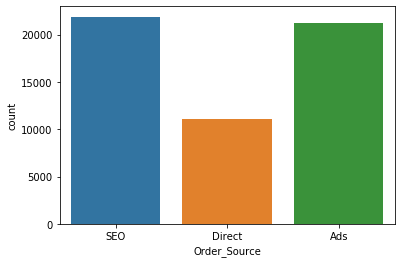

SEO       21884
Ads       21259
Direct    11070
Name: Order_Source, dtype: int64

In [78]:
sns.countplot(x='Order_Source', data=train_data)
plt.show()
train_data.Order_Source.value_counts()

In [79]:
X_train.describe()

,Age,Order_Value_USD
count,54213.000000,54213.000000
mean,33.122240,92.230240
std,8.630091,45.673263
min,18.000000,22.000000
25%,27.000000,55.000000
50%,32.000000,88.000000
75%,39.000000,122.000000
max,72.000000,385.000000


Distribution of 'Age' is fairly symmetrical. Mean = 33.12, Median = 32

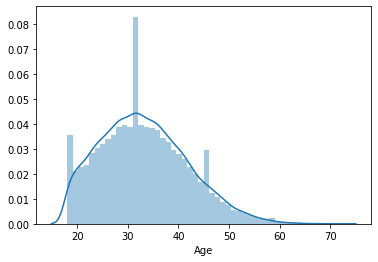

In [80]:
# Check distribution of age
# Density Curve + Histogram, shows distribution of Continuous Feature
%matplotlib inline
sns.distplot(train_data["Age"]) #NT: y is percentage count 

In [81]:
train_data['Order_Payment_Method'].value_counts(normalize = True)

Credit Card         0.402929
Internet Banking    0.243355
Debit Card          0.167303
E-wallet            0.161197
Cash On Delivery    0.025215
Name: Order_Payment_Method, dtype: float64

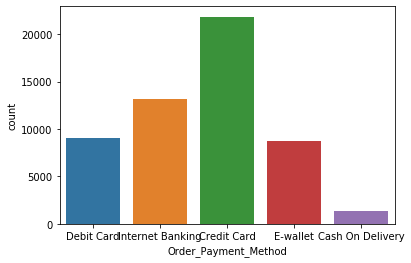

Credit Card         21844
Internet Banking    13193
Debit Card           9070
E-wallet             8739
Cash On Delivery     1367
Name: Order_Payment_Method, dtype: int64

In [82]:
sns.countplot(x='Order_Payment_Method', data=train_data)
plt.show()
train_data.Order_Payment_Method.value_counts()

**Notes on Qualitative Features**

'Order_Source': Has 3 Levels - SEO, Ads, Direct

'Order_Payment_Method': Has 5 Levels - Credit Card, Internet Banking, Debit Card, E-wallet, Cash On Delivery

'IP_Address': Should be converted to Human readable format (Decimal)

'Order_Source', 'Order_Payment_Method', 'Gender': Can be converted to 'category' dtype

In [83]:
X_train[['Order_Source', 'Order_Payment_Method', 'Gender']] = X_train[['Order_Source', 'Order_Payment_Method', 'Gender']].astype('category')
X_test[['Order_Source', 'Order_Payment_Method', 'Gender']] = X_test[['Order_Source', 'Order_Payment_Method', 'Gender']].astype('category')

In [84]:
X_train.dtypes

Merchant_ID                     object
Merchant_Registration_Date      object
Registered_Device_ID            object
Gender                        category
Age                              int64
IP_Address                      object
Customer_ID                     object
Order_ID                        object
Date_of_Order                   object
Order_Value_USD                  int64
Order_Source                  category
Order_Payment_Method          category
dtype: object

In [85]:
X_train['IP_Address'].head()

0     48.151.136.76
1      94.9.145.169
2     58.94.157.121
3    193.187.41.186
4     125.96.20.172
Name: IP_Address, dtype: object

**IP Address Country  step was abandoned due to Long processing time**

In [36]:
# !pip install ip2geotools

from ip2geotools.databases.noncommercial import DbIpCity
list_1 = train_data['IP_Address'][:100].values.tolist()
list_2 = []

In [37]:
for i in range(20):
    try:
        x = DbIpCity.get(list_1[i], api_key='free').country
        list_2.append(x)
    except:
        list_2.append(np.nan)
list_2

['US',
 'GB',
 'JP',
 'AT',
 'CN',
 nan,
 'US',
 'CN',
 'JP',
 'IT',
 'US',
 'US',
 'KR',
 'US',
 'EG',
 'JP',
 'CA',
 'US',
 'KR',
 'US']

In [34]:
train_data.head()

,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,Order_Source,Order_Payment_Method,Fraudster
0,50448,01-05-18 21:15,VATQMMZTVOZUT,F,39,48.151.136.76,129697,3b8983a83c7b,2018-07-30 10:59:13,90,SEO,Debit Card,0
1,338754,14-04-18 10:13,LJCILLBRQZNKS,M,35,94.9.145.169,117390,34b5eb921228,2018-06-15 11:19:47,98,SEO,Internet Banking,0
2,291127,20-06-18 7:44,JFVHSUGKDAYZV,F,40,58.94.157.121,120162,41a1c86ff08b,2018-08-13 10:06:26,95,SEO,Credit Card,0
3,319919,27-06-18 1:41,WFRXMPLQYXRMY,M,37,193.187.41.186,128228,e8c3ad80d916,2018-07-22 15:46:51,100,Direct,E-wallet,0
4,195911,05-01-18 0:55,GGHKWMSWHCMID,F,27,125.96.20.172,136029,e71ab1f26785,2018-04-16 08:02:44,78,SEO,E-wallet,0


### Feature Engineering

Using IP Bound info, Country of transaction origin can be found

**NOTE: Due to high processing and search time this step was abandoned even though being logically valid**

In [86]:
X_test.head()

,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,Order_Source,Order_Payment_Method
0,53637,2018-02-11 20:50:29,PTMLBENYMQCTV,F,40,134.162.124.62,157068,a032de091f51,2018-03-09 09:09:42,60,SEO,Credit Card
1,243517,2018-04-06 13:19:39,HMCLDZUZPWZRR,M,39,152.76.98.87,112534,0d563f0606d6,2018-06-13 20:11:19,28,SEO,Credit Card
2,343640,2018-01-12 16:47:49,VLGSMAPXISSEJ,M,23,31.202.3.255,148774,18fb0fa888b6,2018-04-14 04:19:36,75,Ads,Debit Card
3,69889,2018-02-19 21:58:52,ZINHISBBOKQXT,M,34,12.242.168.185,114528,ed1eb920d721,2018-04-01 13:55:44,98,SEO,Credit Card
4,125706,2018-05-17 15:50:19,WFKEAOTPHTYEO,M,20,26.61.210.47,120940,313dcf962627,2018-05-25 02:08:18,35,SEO,Credit Card


**Model Building 1**: Logistic Regression

In [87]:
tn_1 = X_train.copy()
tt_1 = X_test.copy()

In [88]:
tn_1.dtypes

Merchant_ID                     object
Merchant_Registration_Date      object
Registered_Device_ID            object
Gender                        category
Age                              int64
IP_Address                      object
Customer_ID                     object
Order_ID                        object
Date_of_Order                   object
Order_Value_USD                  int64
Order_Source                  category
Order_Payment_Method          category
dtype: object

In [89]:
num_attr = list(tn_1.select_dtypes('int64').columns)
cat_attr = list(tt_1.select_dtypes('category').columns)

In [90]:
# Numerical Pipeline: Pipeline has 2 operation - SimpleImputer() + StandardScaler()
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])    

# Categorical Pipeline: Pipeline has 2 operation - SimpleImputer() + OneHotEncoder()
categorical_transformer = Pipeline(steps =[('onehot', OneHotEncoder(handle_unknown='ignore'))])
#SimpleImputer strategy ='constant', then fill_values = 'Constant value string written here'

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_attr),
        ('cat', categorical_transformer, cat_attr)])

In [91]:
clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', LogisticRegression())])

In [92]:
y_train.shape

(54213, 1)

In [93]:
clf_logreg.fit(tn_1, y_train)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['Age', 'Order_Value_USD']), ('ca...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [96]:
train_pred = clf_logreg.predict(tn_1)
test_pred = clf_logreg.predict(tt_1)

print(clf_logreg.score(tn_1, y_train))
print(confusion_matrix(y_true=y_train, y_pred = train_pred))

0.9073100547839079
[[49188     0]
 [ 5025     0]]


In [104]:
test_pred_logreg_df = pd.DataFrame({'Fraudster':test_pred})
logreg_df = pd.concat([X_test['Merchant_ID'], test_pred_logreg_df], axis = 1)
logreg_df.to_csv("LogReg_sample.csv", index = False)

In [108]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Conf Matrix : \n", confusion_matrix(y_train, train_pred))
print("\nTrain DATA ACCURACY",accuracy_score(y_train, train_pred))
print("\nTrain DATA Precision", precision_score(y_train, train_pred))
print("\nTrain DATA Recall", recall_score(y_train, train_pred))
print("\nTrain data f1-score for class '1'",f1_score(y_train, train_pred,pos_label=1))
print("\nTrain data f1-score for class '0'",f1_score(y_train, train_pred,pos_label=0))

Conf Matrix : 
 [[49188     0]
 [ 5025     0]]

Train DATA ACCURACY 0.9073100547839079

Train DATA Precision 0.0

Train DATA Recall 0.0

Train data f1-score for class '1' 0.0

Train data f1-score for class '0' 0.9514027910755215


In [107]:


# Accuracy_test=(confusion_matrix[0,0]+confusion_matrix[1,1])/(confusion_matrix[0,0]+confusion_matrix[0,1]+confusion_matrix[1,0]+confusion_matrix[1,1])
# #Acc=
# Precision_Test= confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
# #Prec=
# Recall_Test= confusion_matrix[1,1]/(confusion_matrix[1,0]+confusion_matrix[1,1])
# #Recall=
# print("Test Precision: ",Precision_Test)
# print("Test Recall: ",Recall_Test)
# print("Train Accuracy: ",Accuracy_test)

TypeError: 'function' object is not subscriptable

**Model 2: Decision Tree Model**

In [99]:
# import time
# start_time = time.time()
clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier()), ])

dt_param_grid = {'classifier__criterion': ['entropy'], 'classifier__max_depth': [10], 
                 "classifier__min_samples_split": [4],"classifier__min_samples_leaf": [5]}
#using double underscore '__' to match hyperparamter value to the 'classifier' or Operation assigned in Pipeline() 

# Add to GridSearchCV
dt_grid = GridSearchCV(clf_dt, param_grid=dt_param_grid, cv=5, refit=True)

# Build Model
dt_grid.fit(X_train, y_train)
# end_time = time.time()
# print("-------%s seconds elapsed----------", (end_time - start_time))

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['Age', 'Order_Value_USD']), ('ca...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__criterion': ['entropy'], 'classifier__max_depth': [10], 'classifier__min_samples_split': [4], 'classifier__min_samples_leaf': [5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [109]:
dt_grid.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 10,
 'classifier__min_samples_leaf': 5,
 'classifier__min_samples_split': 4}

In [110]:
train_pred = dt_grid.predict(X_train)
test_pred = dt_grid.predict(X_test)

print(dt_grid.score(X_train, y_train))
print(confusion_matrix(y_true=y_train, y_pred = train_pred))

confusion_matrix_test = confusion_matrix(y_true=y_train, y_pred =  train_pred)


0.9094497629719809
[[49084   104]
 [ 4805   220]]


In [112]:
print("Conf Matrix : \n", confusion_matrix(y_train, train_pred))
print("\nTrain DATA ACCURACY",accuracy_score(y_train, train_pred))
print("\nTrain DATA Precision", precision_score(y_train, train_pred))
print("\nTrain DATA Recall", recall_score(y_train, train_pred))
print("\nTrain data f1-score for class '1'",f1_score(y_train, train_pred,pos_label=1))
print("\nTraom data f1-score for class '0'",f1_score(y_train, train_pred,pos_label=0))

Conf Matrix : 
 [[49084   104]
 [ 4805   220]]

Train DATA ACCURACY 0.9094497629719809

Train DATA Precision 0.6790123456790124

Train DATA Recall 0.04378109452736319

Train data f1-score for class '1' 0.08225836604972893

Traom data f1-score for class '0' 0.9523754086750681
